<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE32338](https://jckantor.github.io/CBE32338)
by Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE2338.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# P control

Dans les travaux précédents on a pu identifier la fonction de transfert liant l'echauffement $Q1$ à la température $T1$ comme :
- un 1er ordre avec retard pur
$$ G_1(s) = \frac{\Delta T_1(s)}{Q_1(s)}= \frac{0.46e^{-21s}}{151s + 1} $$
- un second ordre
$$ G_1(s) = \frac{\Delta T_1(s)}{Q_1(s)}= \frac{0.46}{(21s + 1)(151s + 1)}  $$

$\Delta T_1$ exprimant ici l'écart relatif entre la température du capteur et la température ambiante (autour de 20°C).

On peut trouver [ici](http://www8.umoncton.ca/umcm-cormier_gabriel/Asservissements/GELE5313_Notes7.pdf) un cours sur les asservissements introduisant les différentes formes de correcteurs. L'approche Ziegler-Nichols de réglage de ces correcteurs est notemment rappelé :
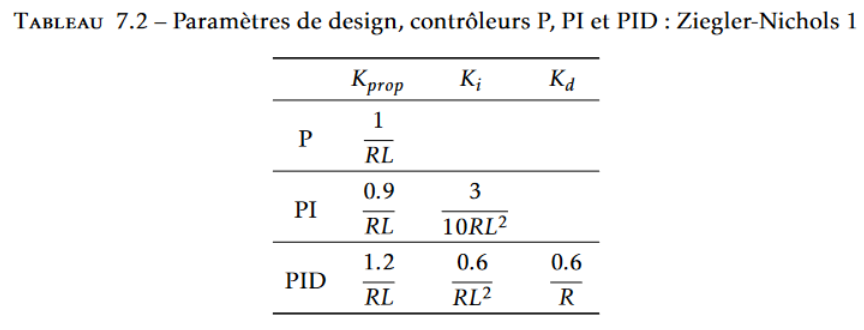

pour un système de fonction de transfert de la forme $ G(s) = \frac{Ke^{-Ls}}{\tau s + 1} $ avec $R=K/\tau$.

Remarque : on peut demontrer que pour un 1er ordre avec retard pur, la pulsation critique menant à un dephasage de -135° (marge de phase de 45°) s'obtient pour   
$\omega_c = \frac{\pi}{4L}$  
avec un gain approximé par 
$|T| \approx \frac{K_p K}{T \omega_c} = 1$
soit $K_p = \frac{T \omega_c}{K} = \frac{\pi T}{4KL}=\frac{\pi }{4RL}$


> Réaliser le controle en température avec correcteur proportionnel de type P. Analyser les performances par simulation de manières temporelles et fréquentielles (Bode en boucle ouverte et boucle fermée). Comparer ces résultats à des essais réels. 




Ici calcul du correcteur  par la methode de Zieghler-Nichols et reponse temporelle de la boucle fermée :

Proportional Gain : 12.27


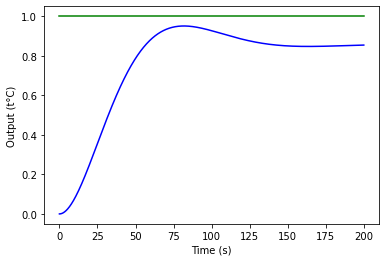

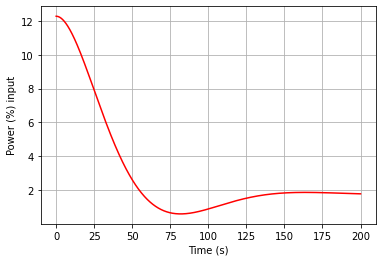

In [200]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import control.matlab as control

# Ziegler Nichols input parameter
tau = 151 # [s] time constant of the 1st order
L= 21 # [s] delay
K = 0.46 # [°/%] static gain

R=K/tau

# control constants
Kp = 3.14/4/R/L

# system transfer function, based on second order model
G1 = 0.49*control.tf([1],[21,1])*control.tf([1],[151,1])

# controller and global model transfer functions
Gc = Kp
print("Proportional Gain : %.2f"%Kp)
T = Gc*G1
H = T/(1+T)



# Step response of the closed loop
t = np.linspace(0,200,1000)
y,t = control.step(H,t)
Q,t = control.step(Kp/(1+T),t)
plt.plot(t,y, 'b', t,np.ones(1000),'g-')
plt.xlabel('Time (s)')
plt.ylabel('Output (t°C)')
plt.show()

plt.plot(t,Q, 'r')
plt.xlabel('Time (s)')
plt.ylabel('Power (%) input')
plt.grid()
plt.show()





Ici tracés des diagrammes de Bode pour le système en boucle ouverte (avec et sans corecteur) et en boucle fermée :

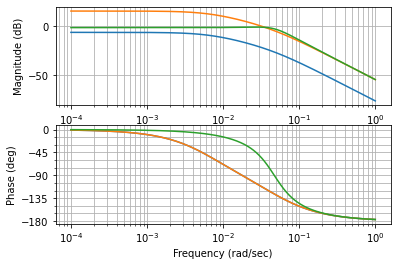

In [201]:
# Bode diagram of open loops
mag,phase,omega = control.bode(G1,T,H)

Ici calcul des marges de gain et de phase :

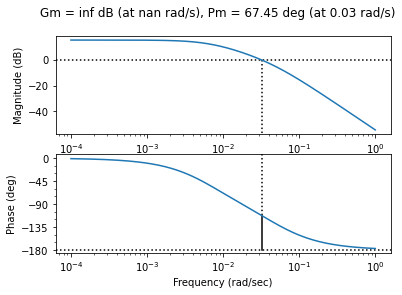

In [202]:
# Print phase and gain margins
mag,phase,omega = control.bode(T, margins = True)

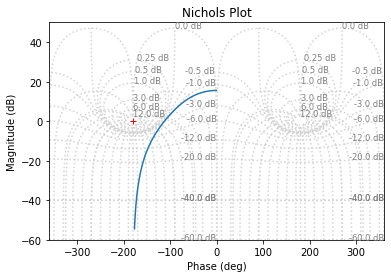

In [203]:
# Print phase and gain margins
control.nichols(T)

Ici réponse temporelle sur la carte TCLab :

In [176]:
from labtime import clock
from tclab import TCLab

#from tclab import TCLab

lab = TCLab()
lab.LED(100)


# from tclab import TCLab

print("Temperature 1: %0.2f °C"%(lab.T1))
print("Temperature 2: %0.2f °C"%(lab.T2))

import matplotlib.pyplot as plt
import numpy as np

time = []
Q1 = []
Kperror = []
T1 = []

Torder = 40

tfinal = 200
tstep = 1


for t in clock(tfinal, tstep):
    print('.', end='')
    error = Torder - lab.T1
    Q = max(0,min(100,Kp*error))
    lab.Q1(Q)
    time = time + [t]
    T1 = T1 + [lab.T1]
    Kperror = Kperror + [Kp*error] 
    Q1 = Q1 + [Q]
    
    
print("\nTurn Heater Q1 Off")
lab.Q1(0)
lab.close()

Opening connection
TCLab connected via Arduino on port COM5
Temperature 1: 20.61 °C
Temperature 2: 20.64 °C
.........................................................................................................................................................................................................
Turn Heater Q1 Off
Arduino disconnected successfully


True

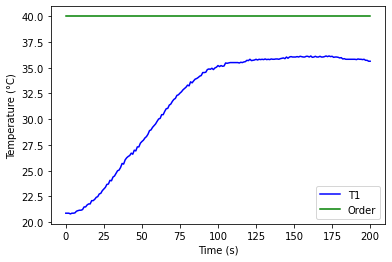

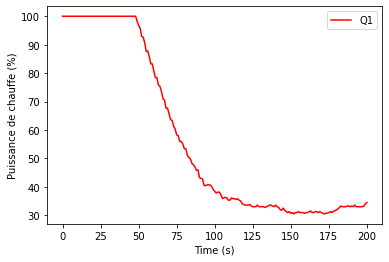

In [177]:
plt.plot(time, T1,'b-', label='T1')
plt.plot(time, np.ones(len(time))*Torder,'g-', label='Order')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

plt.plot(time, Q1,'r-', label='Q1')
plt.xlabel('Time (s)')
plt.ylabel('Puissance de chauffe (%)')
plt.legend()
plt.show()


In [163]:
lab.close()

Arduino disconnected successfully


True

On observe :
- un ecart entre les simulations et les essais expliquées par les saturations (100% et 0%).
- une erreur statique similaire qui necessitent une composante intégrale pour etre annulée.

On peut aussi simuler le correcteur et le modele pour voir si la prise en compte de la saturation peut reproduire les mesures.
$$ G_1(s) = \frac{0.46}{(21s + 1)(151s + 1)} $$


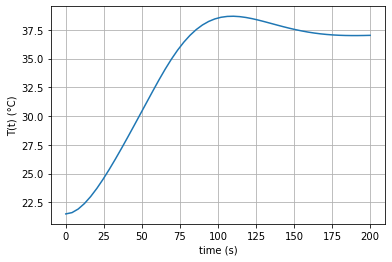

In [205]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Torder=40

# function that returns dy/dt
def model(y,t):
    T, Tp = y
    # Controller
    error = Torder - T
    Q = max(0,min(100,Kp*error))
    # System
    Tpp = (0.46*Q-(T-21.5)-151*Tp)/(21*151)
    dydt = [Tp, Tpp]
    return dydt 

# initial condition
T0 = [21.5,0]

# time points
t = np.linspace(0,200)

# solve ODE
y = odeint(model,T0,t)

# plot results
plt.plot(t,y[:,0])
plt.xlabel('time (s)')
plt.ylabel('T(t) (°C)')
plt.grid()
plt.show()


